In [2]:
import sys
import os
from pathlib import Path

# Handling the scenario where __file__ might not be defined
if '__file__' in globals():
    # If __file__ is defined, use it to get the current directory
    current_dir = Path(os.path.dirname(os.path.abspath(__file__)))
else:
    # If __file__ is not defined, fall back to the current working directory
    current_dir = Path(os.getcwd())

# Calculate the parent directory
parent_dir = current_dir.parent

# Append the parent directory to sys.path
sys.path.append(str(parent_dir))


In [3]:
import geopandas as gpd
import requests
import os
from shapely.geometry import Polygon, LineString, MultiLineString
import io
import osmnx as ox
from shapely import Point
from mapclassify import greedy
import momepy
import shapely
from shapely.ops import split, snap, unary_union


/home/virgilxw/miniforge3/envs/downloader/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [5]:
# Parameters
local_crs = 27700
place = "Bristol"
lat = 51.453611
lng = -2.5975
country = "UK"
crs = 4326
radius = 20


In [6]:
latlng = (lat, lng)

In [7]:
if not os.path.exists(f'../output/{place}'):
    os.makedirs(f'../output/{place}')

## part 1: Find limits of cells to download

In [33]:

# Base URL for the FeatureServer
base_url = "https://services.arcgis.com/qHLhLQrcvEnxjtPr/ArcGIS/rest/services/OS_OpenMap_Local_Buildings/FeatureServer/1/query"

# Parameters
params = {
    # ... other parameters remain unchanged ...
    "geometry": f'{{"x": {lng}, "y": {lat}, "spatialReference": {{"wkid": 4326}}}}',
    "geometryType": "esriGeometryPoint",
    "spatialRel": "esriSpatialRelIntersects",
    "distance": (radius+5)*1000,  # 5km converted to meters
    "units": "esriSRUnit_Meter",  # Ensure units are in meters
    # ... other parameters remain unchanged ...
    "f": "GEOJSON",
    "token": "",  # Add token if necessary,
    "returnExceededLimitFeatures":"true"
}

# Make the GET request
response = requests.get(base_url, params=params)

# Check the status code and print the result
if response.status_code == 200:
    print("Success:")
    print(response.text)  # Or process the response as you need
else:
    print("Failed to retrieve data")
    print(response.status_code)

Success:
{"type":"FeatureCollection","properties":{"exceededTransferLimit":true},"features":[{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-2.59745132542816,51.4539682046728],[-2.59742781515732,51.4539642783535],[-2.59749360474953,51.4538113485021],[-2.59751711611366,51.4538153647219],[-2.59745132542816,51.4539682046728]]]},"properties":{"ID":"93A4A861-6CA0-4521-B8DB-AE213C50DB21"}},{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-2.59689452981577,51.4538823861543],[-2.59686929389332,51.4538785584485],[-2.59692873461714,51.4537242226044],[-2.59695397045083,51.4537280502973],[-2.59689452981577,51.4538823861543]]]},"properties":{"ID":"04BC651C-C00A-4597-A9EE-60D5E1DB8D0F"}},{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-2.5970118230596,51.4540698098191],[-2.59703792961648,51.4540741725702],[-2.59697367521306,51.4542235874382],[-2.5969475685685,51.4542192246727],[-2.5970118230596,51.4540698098191]]]},"properties":{"ID":"A4CC8115-F9EF-49E

In [34]:
# Convert the string to a file-like object
geojson_file_like = io.StringIO(response.text)

# Read into a GeoDataFrame
downloaded_gdf = gpd.read_file(geojson_file_like)

In [35]:
downloaded_gdf.explore()

In [10]:
buffer = gpd.GeoDataFrame(index=[0], geometry=[Point(lng, lat)], crs=4326).to_crs(local_crs).buffer((radius+5)*1000).to_crs(4326)

In [11]:
buffer.explore()

In [12]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

/tmp/ipykernel_381233/2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [13]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

water_gdf = water_gdf.reset_index(drop=True)

In [14]:
water_gdf.to_parquet(f"../output/{place}_OS/water.pq")

In [15]:
buffer = gpd.GeoDataFrame(geometry=buffer, crs=4326)

In [16]:
if country == None:
    world_poly = gpd.read_file(f"../input/{place}_study_area.shp")
else:
    world_poly = gpd.read_file(f"../input/{country}_study_area.shp")

In [17]:
study_area = gpd.overlay(world_poly, buffer, how='intersection').overlay(water_gdf, how='difference')

In [18]:
streets = gpd.read_parquet("../input/gitignore/os-roads/merged_roads.parquet")

In [19]:
streets = streets.to_crs(4326)

In [20]:
# List of all column names to be dropped
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop the columns
streets = streets.drop(columns=columns_to_drop)

In [21]:
streets = gpd.sjoin(streets, buffer, how="inner", op="intersects")

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [22]:
# streets.explore()

In [23]:
streets = streets.drop(columns="index_right")

In [24]:
streets = streets.explode()

/tmp/ipykernel_381233/958103756.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = streets.explode()


In [25]:

# Assuming you have a GeoDataFrame named 'gdf' with your data

def convert_geometry(geom):
    if geom.geom_type == 'LineStringZ':
        return LineString([(x, y) for x, y, z in geom.coords])
    else:
        return geom  # Return the geometry unchanged if it's not LineStringZ or MultiLineString

# Apply the conversion to each geometry in the GeoDataFrame
streets['geometry'] = streets['geometry'].apply(convert_geometry)

In [26]:
downloaded_gdf.to_parquet(f"../output/{place}_OS/buildings_raw.pq")

In [27]:
streets.to_parquet(f"../output/{place}_OS/streets_raw.pq")

In [28]:
osm_graph= ox.graph.graph_from_polygon(buffer.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()

# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))
        
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [29]:
rail_noded_gdf.explore()

In [30]:
rail_noded_gdf.to_parquet(f"../output/{place}_OS/rail_raw.pq")

In [31]:
study_area.to_parquet((f"../output/{place}_OS/study_area.pq"))

<Axes: >

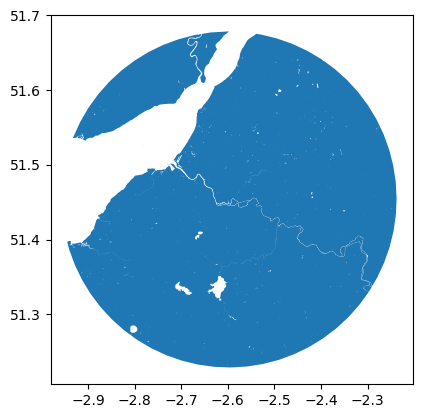

In [32]:
study_area.plot()